# less stochastic optimizer


# 3. optimization per minibatch


## 3.1 gradient descent method

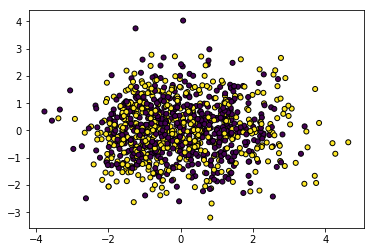

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import datasets
n_features = 10
X, label = datasets.samples_generator.make_classification(
    n_samples=1000, n_features=n_features, n_redundant=0, n_informative=2, n_clusters_per_class=2, flip_y=0.1, random_state=1)


plt.scatter(X[:, 0], X[:, 1], marker='o', c=label, s=25, edgecolor='k')

In [2]:
import copy

class base(object):
    @staticmethod
    def tanh(x, derivative=False):
        return np.tanh(x) if derivative==False else np.arctanh(x)
    
    @staticmethod
    def relu(x, derivative=False):
        if derivative==False:
            return np.maximum(x, 0, x)
        else:
            _ = x.reshape( (np.prod(x.shape), ) )
            return np.array( [(1.0 if v>0 else 0.0) for v in _] ).reshape( x.shape )

    @staticmethod
    def sigmoid(x, derivative=False):
        f = lambda v: 1. / (1. + np.exp(-v))
        return f(x) if derivative==False else f(x) * f(1-x)
    
    @staticmethod
    def x_entropy(y_hat, y):
        EPS = 1e-6
        return -np.mean( np.log(y_hat+EPS) * y + np.log(1.-y_hat+EPS) * (1.0 - y) )


class model(base):
    def __init__(self, num_params=2, num_layers=3, activation=base.relu):
        self.activation = activation
        self.W = [np.random.uniform(-1.0, 1.0, (num_params, num_params)) for i in range(num_layers)]
        self.W.append( np.random.uniform(-1.0, 1.0, (num_params, 1)) )
        self._W = copy.deepcopy(self.W)
        self.outputs = []
        self.gradients = []
        
    def store(self):
        self._W = copy.deepcopy(self.W)
        
    def reset(self):
        self.W = copy.deepcopy(self._W)
        
    def forward(self, X):
        self.outputs = []
        self.gradients = []
        x = X
        for w in self.W[:-1]:
            a = np.dot(x, w)
            z = self.activation(a)
            self.outputs.append( {'x':x, 'a':a, 'z':z} )
            self.gradients.append( {'w':None} )
            x = z
        a = np.dot(x, self.W[-1])
        z = a
        self.outputs.append( {'x':x, 'a':a, 'z':z} )
        self.gradients.append( {'w':None} )
        return z
    
    def predcit(self, X):
        return base.sigmoid( self.forward(X) )
    
    def loss(self, X, y):
        return base.x_entropy( self.predcit(X), y)
    
    def backward(self, X, y):
        delta = self.forward(X) - y.reshape(-1, 1)
        delta_a = delta / (1.0 * y.shape[0])
        delta_x = np.dot(delta_a, self.W[-1].T)
        delta_z = delta_x
        
        delta_w = np.dot( self.outputs[-1]['x'].T, delta_a )
        self.gradients[-1]['w'] = delta_w

        reversed_index = reversed(range(len(self.W)-1))
        for index in reversed_index:
            W = self.W[index]
            x = self.outputs[index]['x']
            
            delta_a = delta_z * self.activation(self.outputs[index]['a'], derivative=True)
            delta_x = np.dot(delta_a, W.T)
            delta_z = delta_x

            delta_w = np.dot( self.outputs[index]['x'].T, delta_a )
            self.gradients[index]['w'] = delta_w
            
        return self

In [3]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from sklearn.utils import shuffle

# Next line to silence pyflakes. This import is needed.
Axes3D

def manifold(model, samplesX, samplesLabel, model_index=0, grids=11):
    parameter_menifold={'space':[], 'loss':[]}
    space_range = 10.0
    for y in np.linspace(-space_range, space_range, num=grids):
        for x in np.linspace(-space_range, space_range, num=grids):
            model.reset()
            model.W[model_index][0, 0], m.W[model_index][1, 0] = x, y
            parameter_menifold['space'].append( (x, y) )
            parameter_menifold['loss'].append( m.loss(samplesX, samplesLabel) )
            
    x = np.array(parameter_menifold['space'])[:, 0].reshape(grids, grids)
    y = np.array(parameter_menifold['space'])[:, 1].reshape(grids, grids)
    z = np.array(parameter_menifold['loss']).reshape(grids, grids)
    parameter_menifold['surface'] = (x, y, z)
    parameter_menifold['z-range'] = (1.0, 4.0)
    return parameter_menifold

def draw(fig, parameter_menifold, point, grad, lr, sub_grids=[1,1], index=1, projection='2d'):
    x = parameter_menifold['surface'][0]
    y = parameter_menifold['surface'][1]
    z = parameter_menifold['surface'][2]
    
    if projection == '2d':
        ax = fig.add_subplot(sub_grids[1], sub_grids[0], index)
        surf = ax.contourf(x, y, z, cmap=cm.coolwarm)
        ax.scatter([point[0]], [point[1]], linewidths=5, c='y', marker='^')
        ax.arrow( point[0], point[1], -grad[0]*lr, -grad[1]*lr,
                 head_width=0.5, head_length=0.5, fc='k', ec='k')
    elif projection == '3d':
        ax = fig.add_subplot(sub_grids[1], sub_grids[0], index, projection='3d')

        surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=.8)
        ax.scatter([point[0]], [point[1]], [point[2]], linewidths=5, c='y', marker='^')
        
        ax.set_zlim(0.5, 3.0)


In [4]:
np.random.seed(0xC0FFEE)
m = model(n_features)
m = m.backward(X, label)

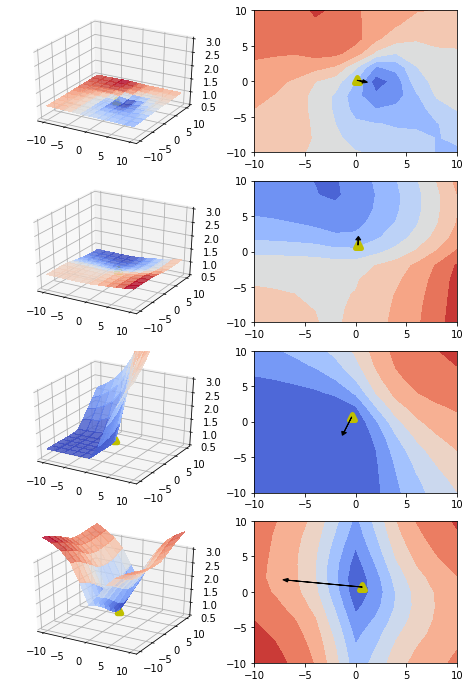

In [5]:
layers = len(m.W)
grids = [2, layers]
fig = plt.figure(figsize=(grids[0]*4, grids[1]*3))

m = m.backward(X, label)
grads = [(g['w'][0, 0], g['w'][1, 0]) for g in m.gradients]

global_parameter_menifolds = []
for layer in range(layers):
    parameter_menifold = manifold(m, X, label, model_index=layer)
    global_parameter_menifolds.append( parameter_menifold )
    m.reset()

    loss = m.loss(X, label)
    point = (m.W[layer][0, 0], m.W[layer][1, 0], loss)
    grad = grads[layer]
    draw(fig, parameter_menifold, point, grad, lr=5.0, sub_grids=grids, index=layer*2+1, projection='3d')
    draw(fig, parameter_menifold, point, grad, lr=5.0, sub_grids=grids, index=layer*2+2, projection='2d')

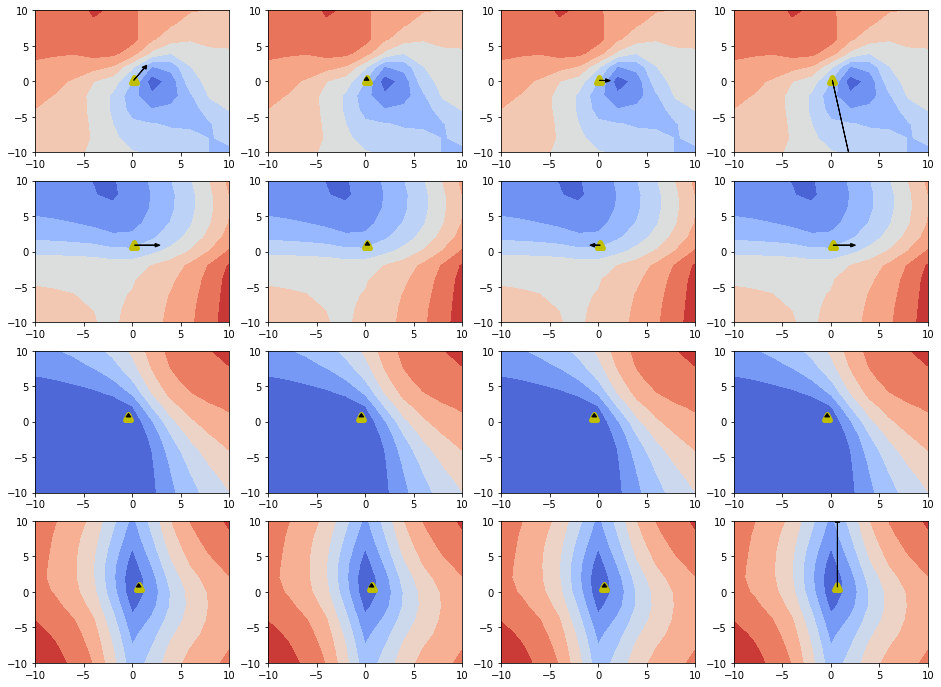

In [6]:
grids = [4, layers]
fig = plt.figure(figsize=(grids[0]*4, grids[1]*3))

m.reset()
for i in range(grids[0]):
    samplesX, samplesLabel = shuffle(X, label, n_samples=1)
    m = m.backward(samplesX, samplesLabel)
    grads = [(g['w'][0, 0], g['w'][1, 0]) for g in m.gradients]

    for layer in range(grids[1]):
        parameter_menifold = global_parameter_menifolds[layer]

        point = (m.W[layer][0, 0], m.W[layer][1, 0])
        grad = grads[layer]
        draw(fig, parameter_menifold, point, grad, lr=5.0, sub_grids=grids, index=layer*grids[0]+i+1)